## **Web Intelligence PBL**
## **Collaborative Filtering based Movie Recommendation Engine**
## Submitted By:
## Ehtesham Ashraf (23303021)
## Sidhant Moza (23303026)
## Himani Agrawal (23303025)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import warnings,random,requests,json,tqdm

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Web_Intel_PBL/IMDbRatingsByUsers.csv',usecols=[1,2,3,4])
df.head()

,UserID,TitleID,Rating,Date
0,ur4592644,tt0120884,10,16 January 2005
1,ur3174947,tt0118688,3,16 January 2005
2,ur3780035,tt0387887,8,16 January 2005
3,ur4592628,tt0346491,1,16 January 2005
4,ur3174947,tt0094721,8,16 January 2005


In [4]:
df.shape

(4669820, 4)

In [5]:
df.drop_duplicates(subset=['UserID', 'TitleID'],inplace=True)
df.shape

(4647097, 4)

In [6]:
df.isnull().sum()

UserID     0
TitleID    0
Rating     0
Date       0
dtype: int64

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.day_name()
df.head()

,UserID,TitleID,Rating,Date,Day,Month,Year,DayOfWeek
0,ur4592644,tt0120884,10,2005-01-16,16,1,2005,Sunday
1,ur3174947,tt0118688,3,2005-01-16,16,1,2005,Sunday
2,ur3780035,tt0387887,8,2005-01-16,16,1,2005,Sunday
3,ur4592628,tt0346491,1,2005-01-16,16,1,2005,Sunday
4,ur3174947,tt0094721,8,2005-01-16,16,1,2005,Sunday


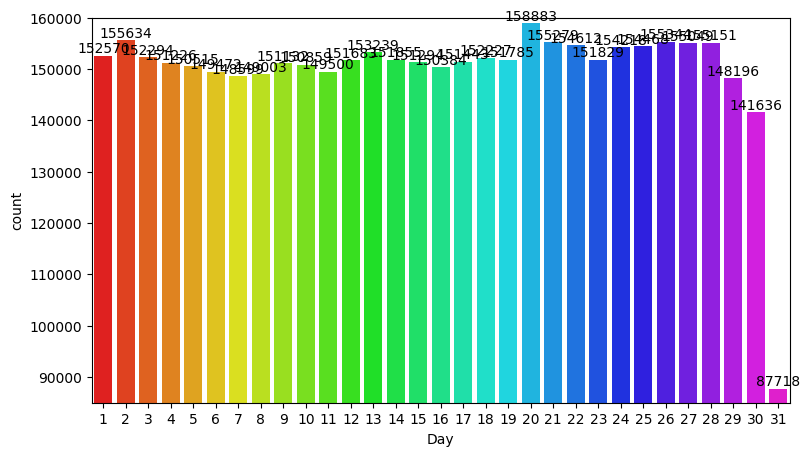

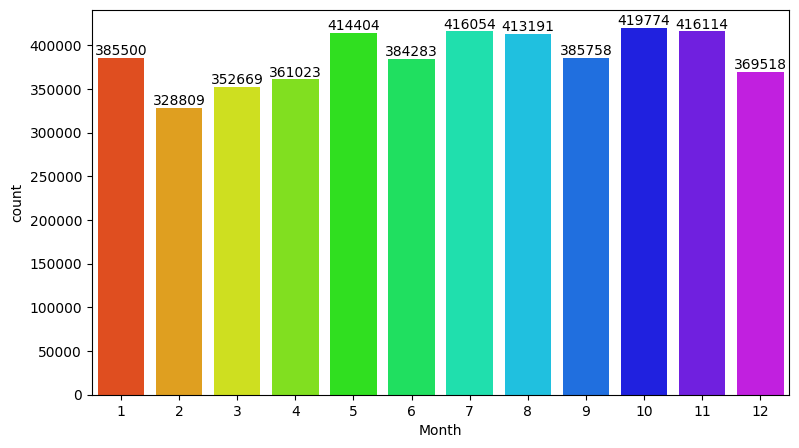

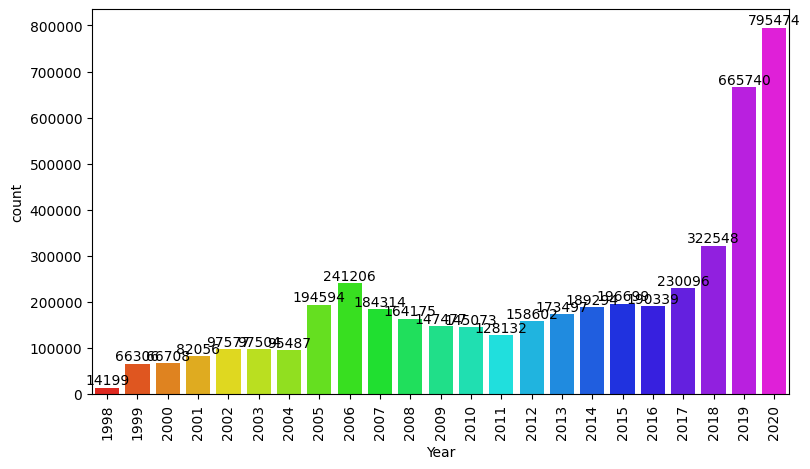

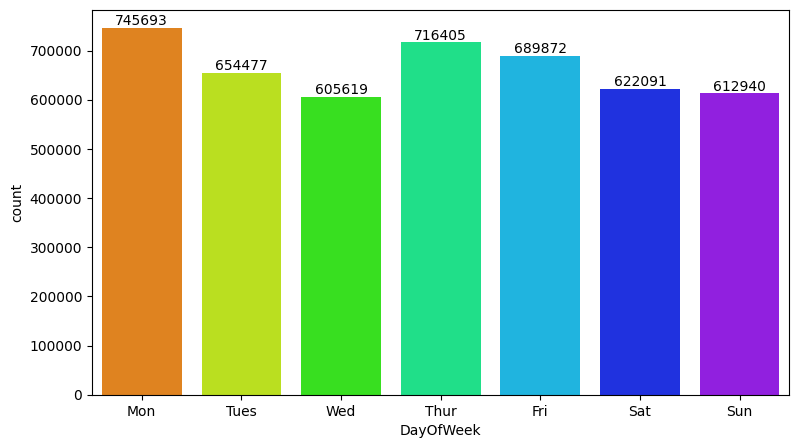

In [8]:
warnings.filterwarnings("ignore")
for i in ['Day','Month','Year','DayOfWeek']:
    fig, ax = plt.subplots(figsize=(9, 5))
    sns.countplot(x=i, data=df, palette='gist_rainbow', ax=ax)
    if i == 'Day':
        plt.ylim(85000,160000)
    if i == 'DayOfWeek':
        plt.xticks(range(7),labels=['Mon','Tues','Wed','Thur','Fri','Sat','Sun'],rotation=0)
    if i == 'Year':
        plt.xticks(rotation=90)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)
    plt.show()

In [9]:
df['TitleID'].value_counts()

TitleID
tt7286456    10407
tt4154796     8695
tt8110330     7667
tt0111161     7499
tt2527338     7428
             ...  
tt0384496        1
tt0390887        1
tt0416867        1
tt0136708        1
tt0174827        1
Name: count, Length: 351109, dtype: int64

In [10]:
topt = list(df['TitleID'].value_counts().index)[:10]
topt

['tt7286456',
 'tt4154796',
 'tt8110330',
 'tt0111161',
 'tt2527338',
 'tt6027920',
 'tt4154664',
 'tt0468569',
 'tt10230426',
 'tt7131622']

In [11]:
df['UserID'].value_counts()

UserID
ur2467618     24107
ur20552756    16802
ur2483625     16703
ur0482513     13206
ur2898520     12676
              ...  
ur4590001         1
ur2571218         1
ur2941454         1
ur4584331         1
ur4589915         1
Name: count, Length: 1499238, dtype: int64

Filtering out users which gave less than or equal to 5 ratings

In [12]:
users = df.groupby('UserID').apply(lambda x: dict(zip(x['TitleID'], x['Rating']))).to_dict()
users = {user: titles for user, titles in users.items() if len(titles) > 5}
print(len(users),"Users Found!")

93744 Users Found!


In [91]:
bins = [0,10,20,50,100,200,300,500,700,1000,2000,3000,5000,10000,20000,30000]
fr = np.zeros(15)
for u,t in users.items():
    l = len(t)
    for i in range(15):
        if (i<15 and l>=bins[i] and l<bins[i+1]) or (i==15 and l>bins[i]):
            fr[i]+=1
for i in range(15):
    print(f"[{bins[i]},{bins[i+1]}] = {fr[i]} ({fr[i]/93744*100:.2f}%)")

[0,10] = 44677.0 (47.66%)
[10,20] = 28700.0 (30.62%)
[20,50] = 13520.0 (14.42%)
[50,100] = 3679.0 (3.92%)
[100,200] = 1740.0 (1.86%)
[200,300] = 530.0 (0.57%)
[300,500] = 368.0 (0.39%)
[500,700] = 184.0 (0.20%)
[700,1000] = 112.0 (0.12%)
[1000,2000] = 139.0 (0.15%)
[2000,3000] = 44.0 (0.05%)
[3000,5000] = 27.0 (0.03%)
[5000,10000] = 19.0 (0.02%)
[10000,20000] = 4.0 (0.00%)
[20000,30000] = 1.0 (0.00%)


In [92]:
histogram = go.Bar(
    x=[f"[{bins[i]}, {bins[i+1]})" for i in range(len(bins)-1)],
    y=fr,
    marker_color='royalblue'
)
fig = go.Figure(data=[histogram])
fig.update_layout(
    title='Frequency Distribution Histogram',
    xaxis=dict(title='Movies Rated'),
    yaxis=dict(title='Number of Users', type='log'),
    bargap=0.2
)
fig.show()

Shuffling the list of 93,744 users

In [27]:
items = list(users.items())
random.shuffle(items)
users2 = dict(items)

Picking first 10 users who have rated atleast 5 of the top 10 rated movies (topt)

In [28]:
c = 0
usrs = []
for u,t in users2.items():
    nr = len(set(t).intersection(set(topt)))
    if nr>5:
        usrs.append(u)
        c+=1
    if c==10:
        break

Sampling only those ratings given by 10 Users selected earlier to top movies

In [29]:
df2 = df[df['UserID'].isin(usrs) & df['TitleID'].isin(topt)]
df2

,UserID,TitleID,Rating,Date,Day,Month,Year,DayOfWeek
709978,ur2707735,tt0468569,10,2008-07-21,21,7,2008,Monday
721320,ur2449095,tt0468569,5,2008-08-14,14,8,2008,Thursday
1030891,ur2449095,tt0111161,8,2004-03-14,14,3,2004,Sunday
1350697,ur2707735,tt0111161,10,2011-07-30,30,7,2011,Saturday
1690866,ur8462477,tt0111161,10,2013-10-17,17,10,2013,Thursday
...,...,...,...,...,...,...,...,...
3731272,ur111092901,tt0468569,9,2020-01-12,12,1,2020,Sunday
3736678,ur111092901,tt4154664,7,2020-01-14,14,1,2020,Tuesday
3766709,ur4569900,tt0468569,7,2020-01-28,28,1,2020,Tuesday
3766710,ur2449095,tt2527338,7,2020-01-28,28,1,2020,Tuesday


In [30]:
utm = df2.pivot_table(index='UserID', columns='TitleID', values='Rating')
utm

TitleID,tt0111161,tt0468569,tt2527338,tt4154664,tt4154796,tt6027920,tt7131622,tt7286456
UserID,,,,,,,,
ur111092901,8.0,9.0,8.0,7.0,8.0,NaN,8.0,10.0
ur18723110,NaN,10.0,3.0,10.0,10.0,10.0,NaN,10.0
ur2449095,8.0,5.0,7.0,5.0,6.0,NaN,8.0,8.0
ur2707735,10.0,10.0,7.0,7.0,8.0,NaN,7.0,10.0
ur3670492,10.0,10.0,5.0,5.0,6.0,NaN,NaN,9.0
ur4569900,NaN,7.0,7.0,6.0,7.0,NaN,6.0,6.0
ur57691865,NaN,10.0,10.0,8.0,10.0,9.0,8.0,8.0
ur70682706,10.0,NaN,5.0,7.0,8.0,NaN,8.0,8.0
ur8462477,10.0,NaN,7.0,7.0,8.0,NaN,9.0,10.0


Scraping title name from IMDb

In [17]:
def get_title_name(tt):
    url = f'https://www.imdb.com/title/{tt}/'
    headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
    response = requests.get(url,headers=headers)
    soup = BeautifulSoup(response.content,'html.parser')
    script_tag = soup.find('script', {'id': '__NEXT_DATA__'})
    json_content = script_tag.contents[0]
    data = json.loads(json_content)
    tn = data["props"]["pageProps"]["aboveTheFoldData"]["titleText"]["text"]
    yr = data["props"]["pageProps"]["aboveTheFoldData"]["releaseYear"]["year"]
    tn = f"{tn} ({yr})"
    return tn

In [18]:
ttn = []
for t in list(utm.columns):
    mv = get_title_name(t)
    print(mv)
    ttn.append(mv)
utm.columns = ttn

The Shawshank Redemption (1994)
The Dark Knight (2008)
Star Wars: The Rise of Skywalker (2019)
Captain Marvel (2019)
Avengers: Endgame (2019)
The Iron Throne (2019)
Once Upon a Time... in Hollywood (2019)
Joker (2019)


Rating Prediction using User-based CF (Only on sample of dataset (utm))

In [31]:
utmx = np.array(utm)
nus = utmx.shape[0]
print("User-Title Ratings:")
print(utmx,'\n')
def cos_sim(v1,v2):
    mask = (v1 != 0) | (v2 != 0)
    v1,v2 = v1[mask],v2[mask]
    n1,n2 = np.linalg.norm(v1),np.linalg.norm(v2)
    if n1==0 or n2==0:
        return 0
    return np.dot(v1,v2)/(n1*n2)
sim = np.zeros((nus,nus))
for i in range(nus):
    for j in range(nus):
        rt1,rt2 = utmx[i][:],utmx[j][:]
        rt1,rt2 = rt1[~np.isnan(rt1) & ~np.isnan(rt2)], rt2[~np.isnan(rt1) & ~np.isnan(rt2)]
        rt1 -= np.mean(rt1)
        rt2 -= np.mean(rt2)
        sim[i][j] = cos_sim(rt1,rt2)
print('Similarity Matrix :\n',sim)
def predRat(uid,iid):
    avg = np.nanmean(np.delete(utmx, iid-1, axis=1), axis=1, keepdims=True)
    pred = avg[uid-1] + np.dot(np.nan_to_num(utmx[:,iid-1]-avg.reshape(1,-1)),sim[uid-1,:])/(abs(sim[uid-1][:]).sum()-1)
    return pred[0]
mode = 2
if mode == 1:
    uid,iid = 2,6
    pred = predRat(uid,iid)
    print(f'\n Rating that User {uid} will give Title {iid} = {pred:.3f}')
elif mode == 2:
    rec = dict()
    for uid in range(nus):
        rs = dict()
        for iid in np.argwhere(np.isnan(utmx[uid,:])).flatten().tolist():
            pred = predRat(uid+1,iid+1)
            rs[utm.columns[iid]] = pred
        rec[utm.index[uid]] = rs
    print("Users\t\t-\tPredictions")
    rec = {user_id: dict(sorted(movies.items(), key=lambda x: x[1], reverse=True)) for user_id, movies in rec.items()}
    for u,p in rec.items():
        preds = {k: round(v) for k, v in p.items()}
        print(f"{u}\t-\t{preds}")

User-Title Ratings:
[[ 8.  9.  8.  7.  8. nan  8. 10.]
 [nan 10.  3. 10. 10. 10. nan 10.]
 [ 8.  5.  7.  5.  6. nan  8.  8.]
 [10. 10.  7.  7.  8. nan  7. 10.]
 [10. 10.  5.  5.  6. nan nan  9.]
 [nan  7.  7.  6.  7. nan  6.  6.]
 [nan 10. 10.  8. 10.  9.  8.  8.]
 [10. nan  5.  7.  8. nan  8.  8.]
 [10. nan  7.  7.  8. nan  9. 10.]
 [nan 10.  7.  7. 10. nan  9.  9.]] 

Similarity Matrix :
 [[ 1.          0.19611614  0.32646431  0.71193614  0.6377928   0.
   0.          0.16609096  0.66409061  0.51970115]
 [ 0.19611614  1.         -0.34299717  0.51604685  0.47673129 -0.40824829
  -0.4152274   0.94280904  0.47140452  0.58976782]
 [ 0.32646431 -0.34299717  1.          0.14834153  0.32854123 -0.39735971
  -0.39735971  0.38729833  0.80295507  0.        ]
 [ 0.71193614  0.51604685  0.14834153  1.          0.98442507  0.12403473
   0.12403473  0.69337525  0.8378689   0.62984387]
 [ 0.6377928   0.47673129  0.32854123  0.98442507  1.          0.
   0.          0.82154192  0.98406272  0.7029019

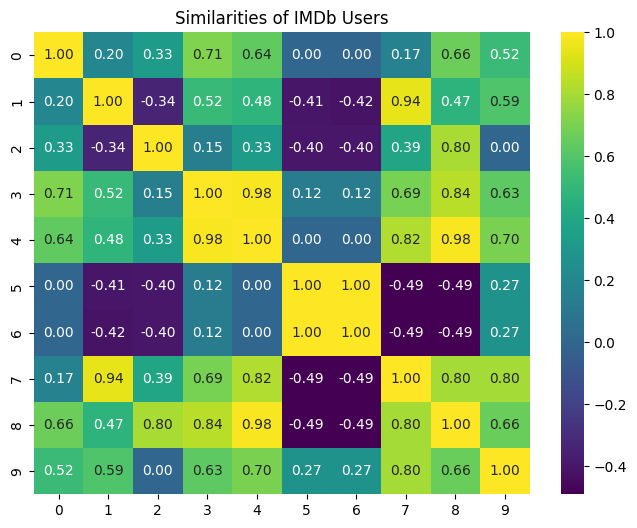

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(sim,cmap="viridis",annot=True,fmt=".2f")
plt.title("Similarities of IMDb Users")
plt.show()

In [33]:
import plotly.graph_objects as go
import numpy as np
x, y = np.meshgrid(np.arange(sim.shape[0]), np.arange(sim.shape[1]))
fig = go.Figure(data=[go.Surface(z=sim, x=x, y=y)])
fig.update_traces(hoverinfo='x+y+z')
fig.update_layout(title='3D Similarity Matrix', autosize=False, width=600, height=600)
fig.show()

### Rating Prediction using CF on whole dataset

Picking a random user

In [34]:
while True:
    rnu = random.choice(list(users.keys()))
    l = len(users[rnu])
    if l>500:
        break
mnu = np.array(list(users[rnu].values())).mean()
print(rnu,"-",len(users[rnu]),"Titles")
print("Avg Rating =",mnu)

ur40547513 - 601 Titles
Avg Rating = 7.336106489184692


In [35]:
test_titles = random.sample(sorted(users[rnu]),round(0.2*l))
test = {t:r for t,r in users[rnu].items() if t in test_titles}
train = {t:r for t,r in users[rnu].items() if t not in test_titles}
mtr = np.array(list(train.values())).mean()
print("Avg Rating of Training set =",mtr)

Avg Rating of Training set = 7.345114345114345


Finding similar users to random user (who have rated similar titles) & computing similarity with random user

In [36]:
rut = set(train)
c = 0
sims = dict()
for u,t in users.items():
    if u==rnu:
        continue
    ct = set(t).intersection(rut)
    if len(ct)>min(0.5*len(rut),10):
        c+=1
        print(f"{c}. Common Titles: {ct}")
        ctu1 = {t:r for t,r in users[rnu].items() if t in ct}
        ctu2 = {t:r for t,r in users[u].items() if t in ct}
        cr = np.array([[ctu1.get(title, np.nan), ctu2.get(title, np.nan)] for title in list(ctu1.keys())],dtype=float)
        cr[:,0] -= cr[:,0].mean()
        cr[:,1] -= cr[:,1].mean()
        sim = cos_sim(cr[:,0],cr[:,1])
        print(f"Similarity b/w {rnu} & {u} = {sim:.3f}\n")
        sims[u] = sim
print("Total",c,"Similar Users Found")

1. Common Titles: {'tt1034415', 'tt8579674', 'tt7784604', 'tt6205872', 'tt7349662', 'tt6565702', 'tt1489887', 'tt3385524', 'tt4614612', 'tt4154664', 'tt8695030', 'tt5117428', 'tt7131622', 'tt1571234', 'tt5083738', 'tt2935510', 'tt5613484'}
Similarity b/w ur40547513 & ur0006042 = 0.053

2. Common Titles: {'tt0164052', 'tt4881806', 'tt8368406', 'tt4633694', 'tt6499752', 'tt2527338', 'tt1477834', 'tt4154664', 'tt3281548', 'tt1706620', 'tt3778644', 'tt6133130', 'tt4595882', 'tt6751668', 'tt6266538', 'tt7549996', 'tt0057869', 'tt7349950', 'tt5308322', 'tt7713068', 'tt2584384', 'tt0437086', 'tt7125860', 'tt5463162', 'tt6348138', 'tt8579674', 'tt7846844', 'tt8079248', 'tt6565702', 'tt3224458', 'tt7658402', 'tt1935859', 'tt8155288', 'tt1560220', 'tt6823368', 'tt3521126', 'tt1856101', 'tt5700672', 'tt5095030', 'tt7286456', 'tt7131622', 'tt0974015', 'tt0252501'}
Similarity b/w ur40547513 & ur0011762 = 0.139

3. Common Titles: {'tt4881806', 'tt2584384', 'tt3778644', 'tt2527338', 'tt6565702', 'tt1

In [37]:
sims

{'ur0006042': 0.05285164225816898,
 'ur0011762': 0.1388908726244082,
 'ur0019286': 0.03265696052517716,
 'ur0101706': 0.44345952510041453,
 'ur0102816': 0.11039815131175877,
 'ur0179626': 0.6107769209825866,
 'ur0225436': 0.01678924422599179,
 'ur0266568': 0.46513420714522313,
 'ur0277234': 0.3218960595762734,
 'ur0278527': 0.34309256121777515,
 'ur0283074': 0.6051603603638209,
 'ur0342623': 0.4934747321939812,
 'ur0345596': 0.30440824745203676,
 'ur0347711': -0.07110681947099658,
 'ur0350543': 0.3682475455538839,
 'ur0351766': 0.4689401761819642,
 'ur0442119': -0.3126526997403612,
 'ur0449021': 0.58095572057968,
 'ur0453068': 0.5863368913008201,
 'ur0453228': 0.4588377785613785,
 'ur0463200': 0.5004291786865414,
 'ur0482513': 0.36593373640431354,
 'ur0492397': 0.07962260575935998,
 'ur0503545': 0.6350999569416319,
 'ur0543054': 0.1933466813423011,
 'ur0547823': 0.31566715278397944,
 'ur0609951': 0.16589950576143966,
 'ur0629528': 0.26325132482650393,
 'ur0633574': 0.6537081739049555,


Predicting ratings for titles that random user has not rated

In [38]:
preds = dict()
cmu = list(sims.keys())
nus = []
for t in test_titles:
    num,den = 0,0
    n = 0
    for u in cmu:
        try:
            r = users[u][t]
            s = sims[u]
            ru = list(users[u].values()) # ratings of user 'u'
            mean = (sum(ru)-r)/(len(ru)-1)
            num += s*(r-mean)
            den += abs(s)
            n+=1
        except KeyError:
            continue
    nus.append(n)
    if den>0:
        preds[t] = mtr + num/den
    else:
        test.pop(t)

In [39]:
zeros = sum(1 for n in nus if n == 0)
print("No. of Titles in Test Set not rated by any SimilarUser =",zeros)

No. of Titles in Test Set not rated by any SimilarUser = 0


In [40]:
preds = dict(sorted(preds.items(), key=lambda x: x[1],reverse=True))
print("Top 10 Titles Predicted for User",rnu,'\n')
tn,pr = [],[]
for t,p in list(preds.items())[:10]:
    tn.append(get_title_name(t))
    pr.append(round(p,3))
prd = pd.DataFrame({"Title Name":tn,"Score":pr})
prd.index+=1
prd

Top 10 Titles Predicted for User ur40547513 



,Title Name,Score
1,Dark (2017),9.135
2,Carrie (1976),8.989
3,Searching (2018),8.592
4,The Wailing (2016),8.415
5,Pájaros de verano (2018),8.326
6,The Nightingale (2018),8.285
7,Bone Tomahawk (2015),8.193
8,I See You (2019),8.122
9,Kona fer í stríð (2018),8.106
10,Bohemian Rhapsody (2018),8.029


In [41]:
ae,ape,se = [],[],[]
for t in test.keys():
    true_r = test[t]
    pred_r = preds[t]
    diff = abs(pred_r-true_r)
    ae.append(diff)
    ape.append(diff/true_r*100)
    se.append(diff**2)
print(f"Mean Absolute Error (MAE) = {sum(ae)/len(ae)}")
print(f"Mean Squared Error (MSE) = {sum(se)/len(se)}")
print(f"Root Mean Squared Error (RMSE) = {(sum(se)/len(se))**0.5}")

Mean Absolute Error (MAE) = 0.8250953944244789
Mean Squared Error (MSE) = 1.0028651481197373
Root Mean Squared Error (RMSE) = 1.0014315493930364


In [42]:
rats = pd.DataFrame({'True': test, 'Predicted': preds})
rats.sort_values(by='Predicted',ascending=False,inplace=True)
rats

,True,Predicted
tt5753856,8,9.135035
tt0074285,8,8.989352
tt7668870,7,8.592264
tt5215952,9,8.415187
tt6386748,9,8.326440
...,...,...
tt7456312,6,4.636805
tt1255919,4,4.561334
tt7895904,6,4.507472
tt7671414,5,3.708576


In [43]:
def calc_dcg(rat):
	dcg = 0
	for i in range(len(rat)):
		dcg += (2**rat[i] - 1)/(np.log2(i+2))
	return dcg
dcg = calc_dcg(rats['True'])
rats.sort_values(by='True',ascending=False,inplace=True)
dcgi = calc_dcg(rats['True'])
ndcg = dcg/dcgi
print(f"NDCG Score = {ndcg:.3f}")

NDCG Score = 0.889


#### **Performance Evaluation of CF Recommender Engine**

#### Evaluating Predictions and Rankings of All users having atleast 500 Ratings (Test Users)

In [72]:
def predict_rating(rnu):
	user = users[rnu]

	test_titles = random.sample(sorted(user),round(0.2*len(user)))
	test = {t:r for t,r in user.items() if t in test_titles}
	train = {t:r for t,r in users[rnu].items() if t not in test_titles}
	mtr = np.array(list(train.values())).mean()

	rut = set(train)
	c = 0
	sims = dict()
	for u,t in users.items():
		if u==rnu:
			continue
		ct = set(t).intersection(rut)
		if len(ct)>min(0.5*len(rut),10):
			c+=1
			ctu1 = {t:r for t,r in users[rnu].items() if t in ct}
			ctu2 = {t:r for t,r in users[u].items() if t in ct}
			cr = np.array([[ctu1.get(title, np.nan), ctu2.get(title, np.nan)] for title in list(ctu1.keys())],dtype=float)
			cr[:,0] -= cr[:,0].mean()
			cr[:,1] -= cr[:,1].mean()
			sim = cos_sim(cr[:,0],cr[:,1])
			sims[u] = sim

	preds = dict()
	cmu = list(sims.keys())
	nus = []
	for t in test_titles:
		num,den = 0,0
		n = 0
		for u in cmu:
			try:
				r = users[u][t]
				s = sims[u]
				ru = list(users[u].values()) # ratings of user 'u'
				mean = (sum(ru)-r)/(len(ru)-1)
				num += s*(r-mean)
				den += abs(s)
				n+=1
			except KeyError:
				continue
		nus.append(n)
		if den>0:
			preds[t] = mtr + num/den
		else:
			test.pop(t)
	return test,preds

def evaluate_user(test,preds):
	if len(test)==0:
		return 0,0,0,0
	ae,ape,se = [],[],[]
	for t in test.keys():
		true_r = test[t]
		pred_r = preds[t]
		diff = abs(pred_r-true_r)
		ae.append(diff)
		ape.append(diff/true_r*100)
		se.append(diff**2)
	mae,mse = sum(ae)/len(ae), sum(se)/len(se)
	rmse = mse**0.5

	rats = pd.DataFrame({'True': test, 'Predicted': preds})
	rats.sort_values(by='Predicted',ascending=False,inplace=True)
	def calc_dcg(rat):
		dcg = 0
		for i in range(len(rat)):
			dcg += (2**rat[i] - 1)/(np.log2(i+2))
		return dcg
	dcg = calc_dcg(rats['True'])
	rats.sort_values(by='True',ascending=False,inplace=True)
	dcgi = calc_dcg(rats['True'])
	ndcg = dcg/dcgi
	return mae,mse,rmse,ndcg

In [73]:
users500 = {u:t for u,t in users.items() if len(t)>500}
n500 = len(users500)
print("No. of users who rated more than 500 movies =",n500)

No. of users who rated more than 500 movies = 530


In [74]:
MAE,MSE,RMSE,NDCG = [],[],[],[]
from tqdm import tqdm
for u in tqdm(users500):
    test,preds = predict_rating(u)
    mae,mse,rmse,ndcg = evaluate_user(test,preds)
    if mae==0 and mse==0 and rmse==0 and ndcg==0:
      print("Spam User Ignored")
      continue
    MAE.append(mae)
    MSE.append(mse)
    RMSE.append(rmse)
    NDCG.append(ndcg)

 92%|█████████▏| 488/530 [20:52<01:09,  1.66s/it]

Spam User Ignored


100%|██████████| 530/530 [22:12<00:00,  2.51s/it]


#### **Results of CF Peformance Evaluation**

In [75]:
print(f"Average MAE for Test Users = {sum(MAE)/len(MAE):.3f}")
print(f"Average MSE for Test Users = {sum(MSE)/len(MSE):.3f}")
print(f"Average RMSE for Test Users = {sum(RMSE)/len(RMSE):.3f}")
print(f"Average NDCG for Test Users = {sum(NDCG)/len(NDCG):.3f}")

Average MAE for Test Users = 1.356
Average MSE for Test Users = 3.208
Average RMSE for Test Users = 1.727
Average NDCG for Test Users = 0.816
